In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import SpectralClustering
from sklearn.metrics import r2_score

from utils import *

# Part 1: Plotting Dimensionally-Reduced Data

This part uses the **get_data** and **graph_pca_invitro** functions to get flow cytometry of many different APCms populations and plot dimensionally-reduced data from them to visualize key trends.

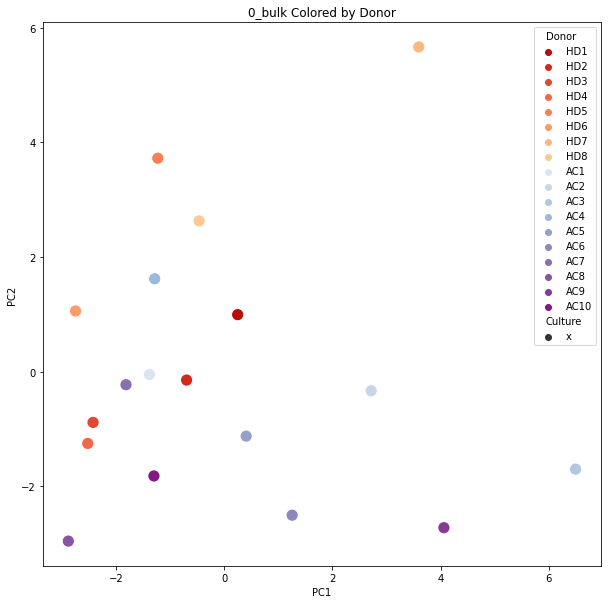

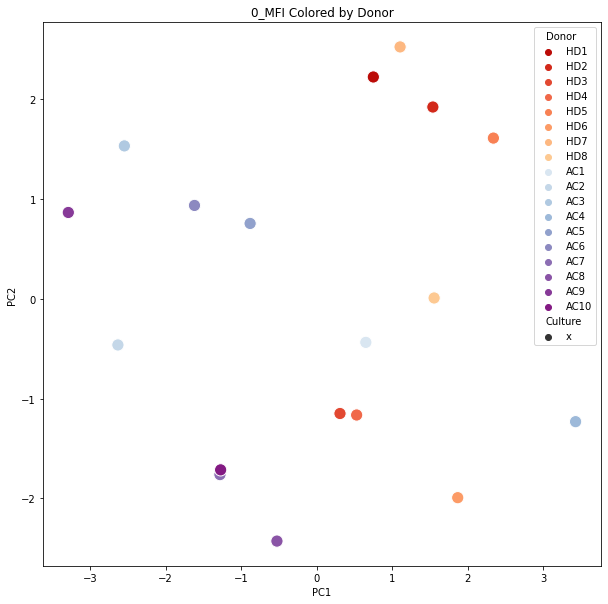

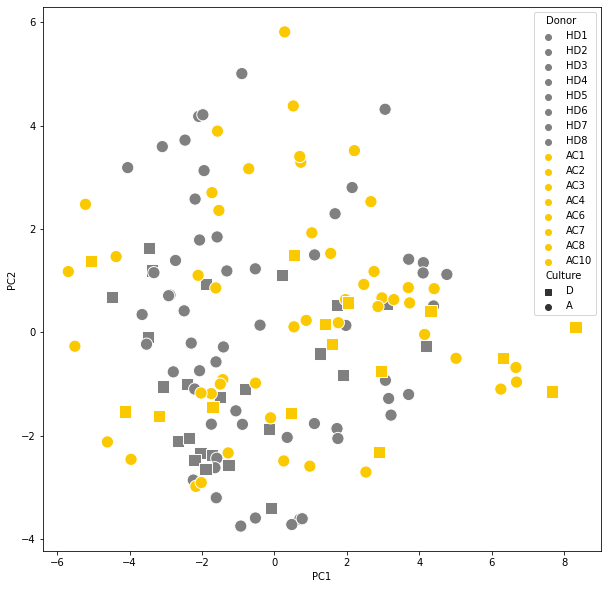

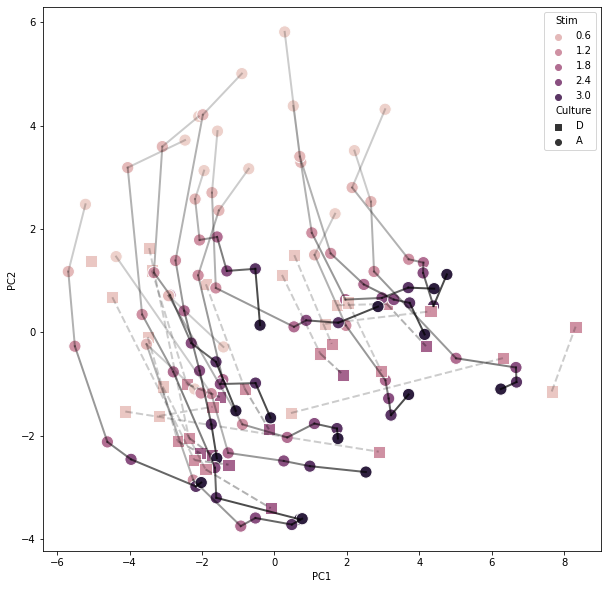

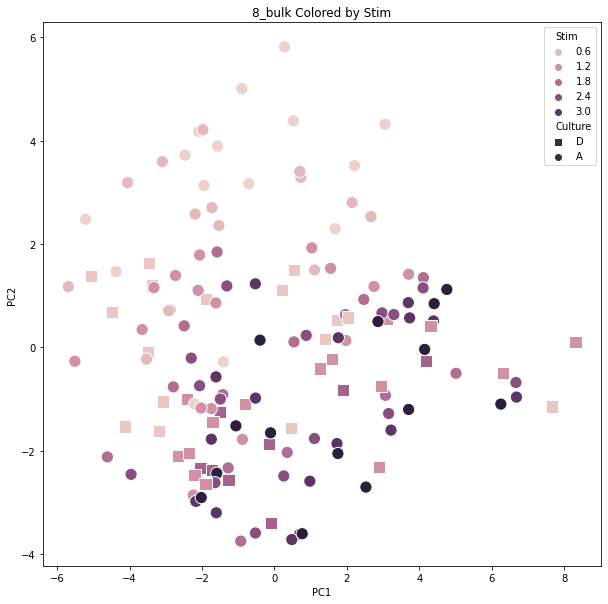

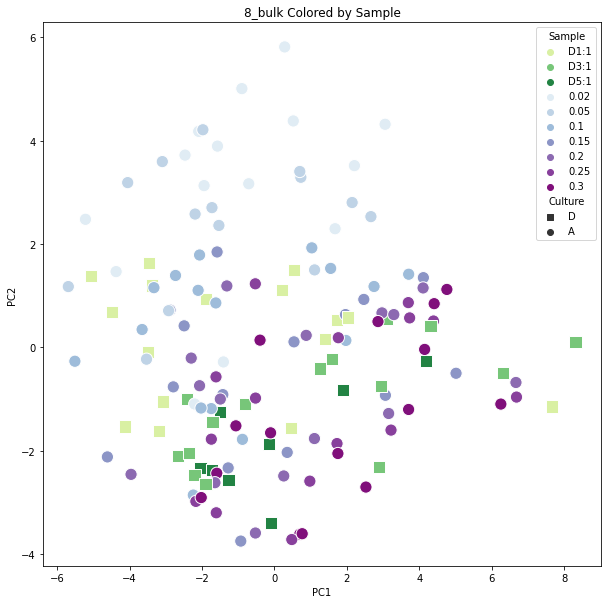

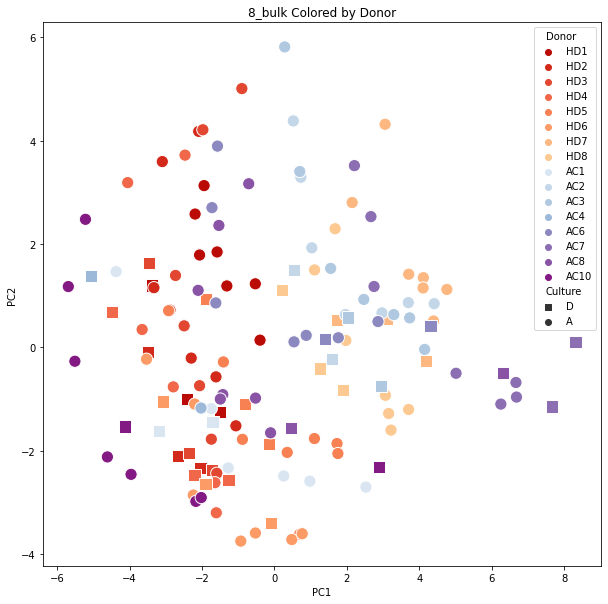

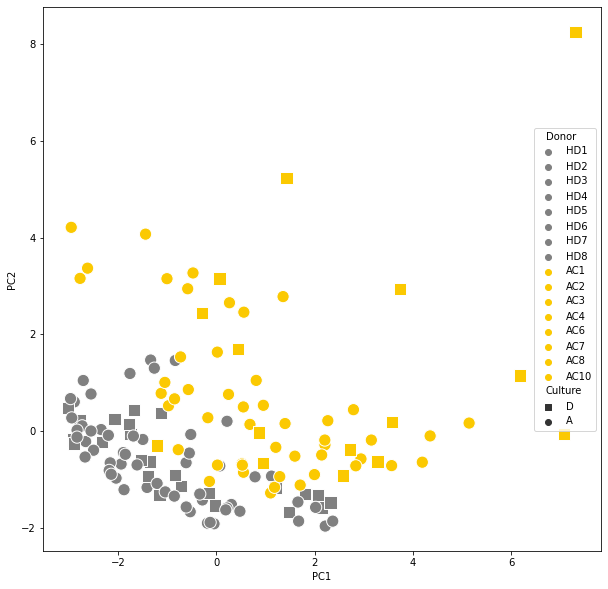

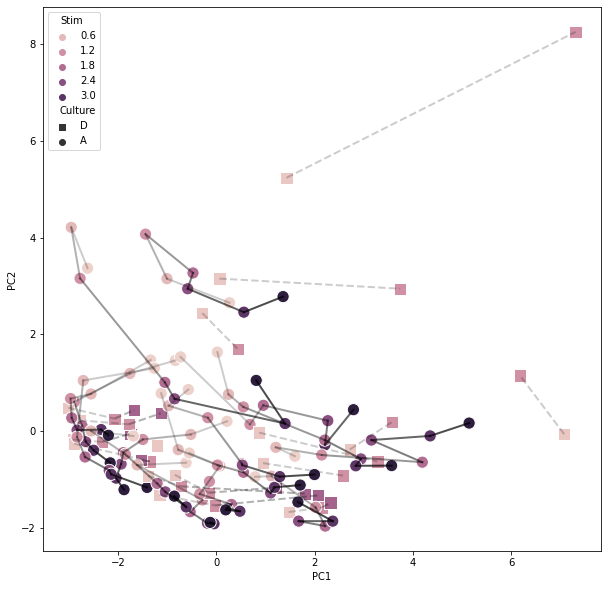

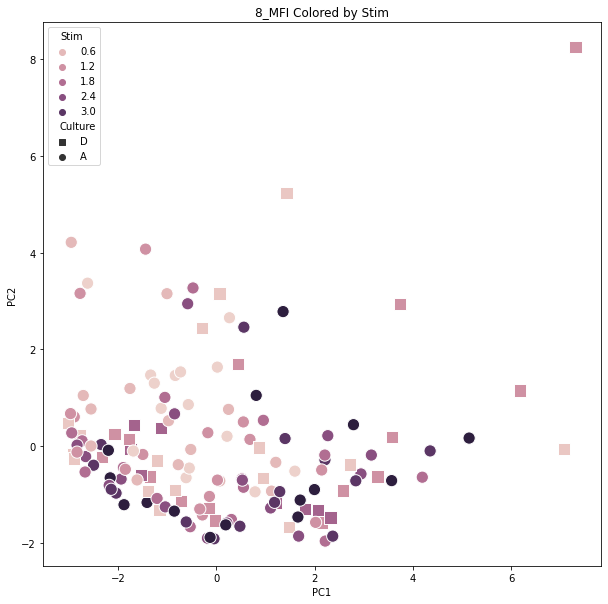

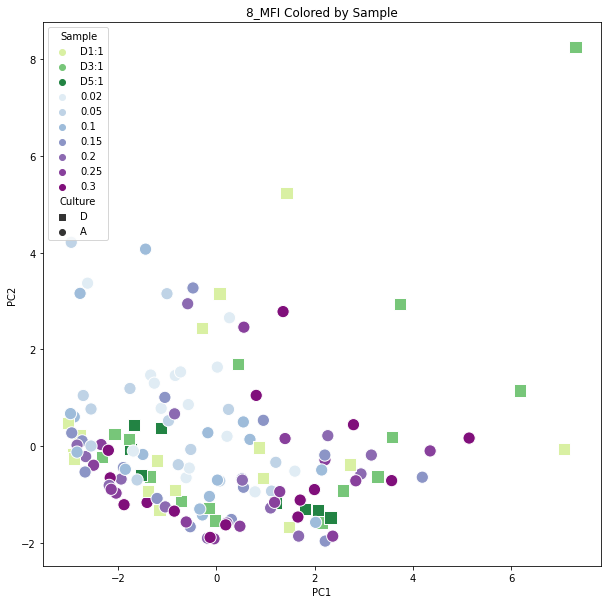

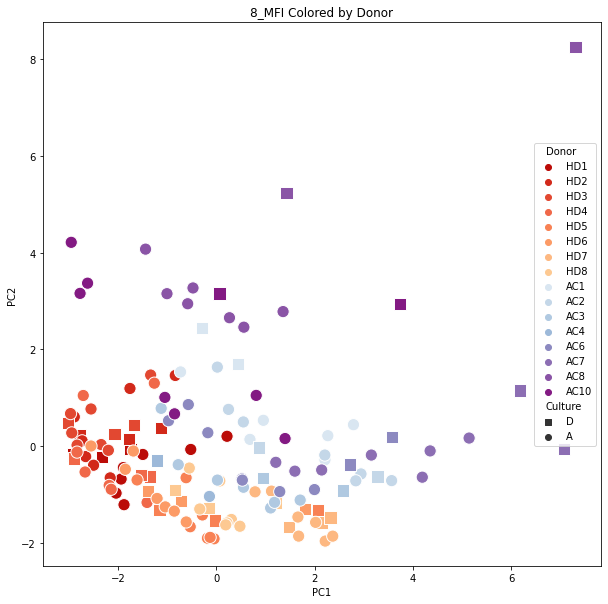

In [2]:
dfs, names= get_data()
donor_dict, sample_dict = produce_color_mapping(dfs[2])


for df, name in zip(dfs, names):
    if name.split('_')[0] == '0':
        palette_dicts= [donor_dict]
        graph_cols = ['Donor']
        graph_pca_invitro(df, name, palette_dicts, graph_cols = graph_cols)
    else:
        palette_dicts= ['none',sample_dict, donor_dict]
        graph_pca_invitro(df, name, palette_dicts)

# Part 2: Clustering and Prediction

Here we will use clustering and different prediction models for three types of predictions.
   1. Is sample X healthy or diseased?
   2. Can the broad phenotype of a T cell product be predicted given its starting phenotype and stimulation dose? 
   2. Given starting phenotype X and end phenotype Y, what stimulation should be applied to X to get Y?

## 1. Is sample X healthy or diseased?

The following code tests different classifiers for their ability to predict whether a day 8 expanded CAR-T product, characterized by the MFI for different surface markers, is from a healthy or diseased patient. Random forest regression performs the best by cross-validation.

Calculating/displaying cross-validation scores for different classifiers:


,Random Forest,MLPC,Decision Tree,Naive Bayes,Nearest Neighbors
0,0.862069,0.758621,0.862069,0.896552,0.535714
1,0.965517,0.689655,0.896552,0.896552,0.678571
2,0.724138,0.827586,0.724138,0.862069,0.642857
3,0.965517,0.758621,0.724138,0.827586,0.642857
4,0.827586,0.724138,0.862069,0.793103,0.642857


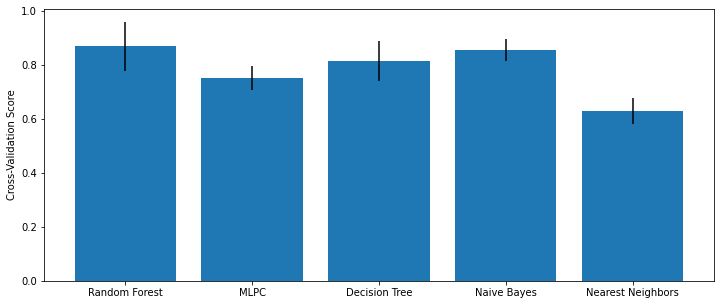

In [3]:
print('Calculating/displaying cross-validation scores for different classifiers:')
classify_ac_hd(dfs[3])

## 2. Can we predict the final product phenotype given the input product phenotype and stimulation? 

Here, we try to predict the cluster of the day 8 product given the day 0 product features and stimulation dose, using  **predict_final_cluster**. 

We can see that different methods are optimal for diseased and healthy products, that the features used for the prediction vary in importance, and that the stimulation dose is the most important feature for this prediction for both healthy and diseased products.

By setting the **grid_search** parameter to **True** you can tune model parameters yourself. You can also choose to try using only stimulation dose to predict the final cluster with the **use_only_stim** parameter.

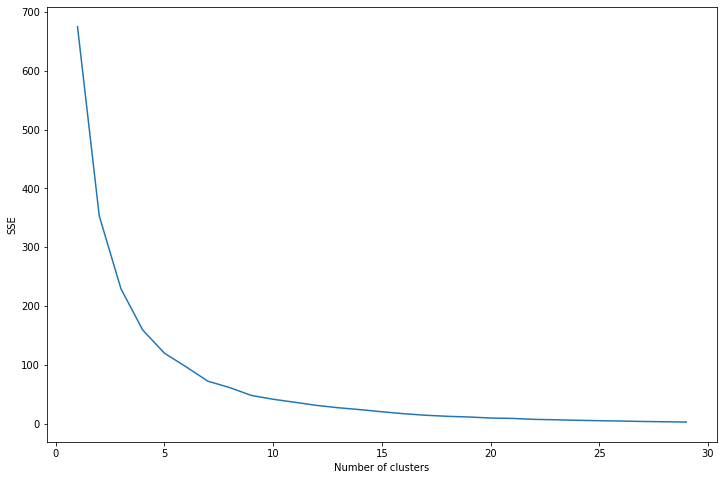

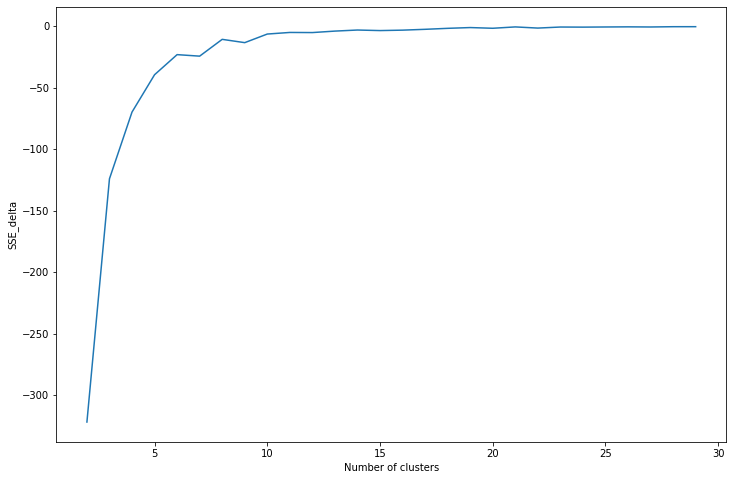

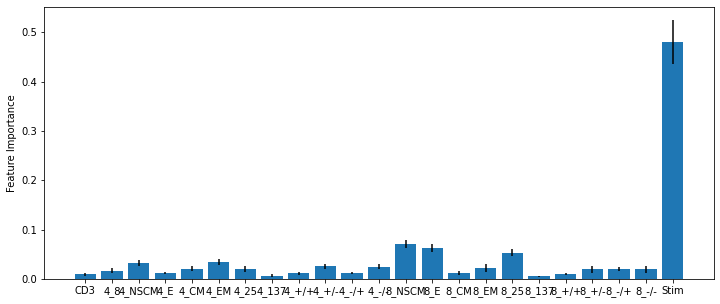

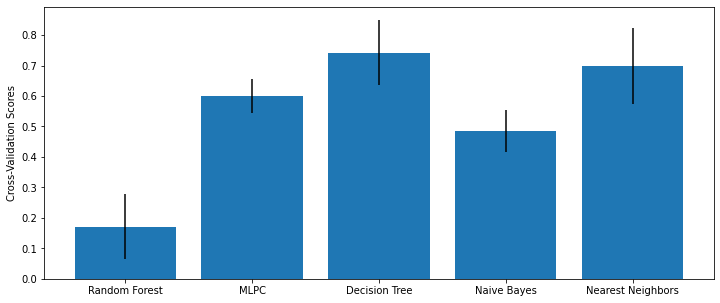

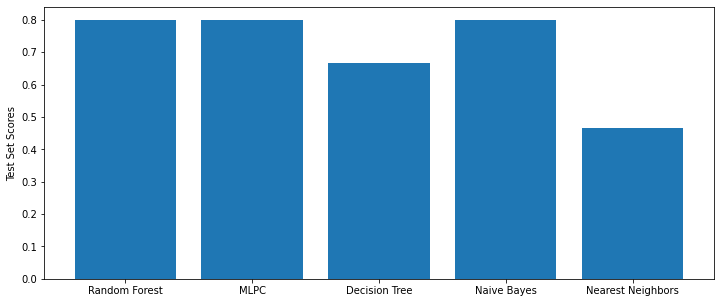

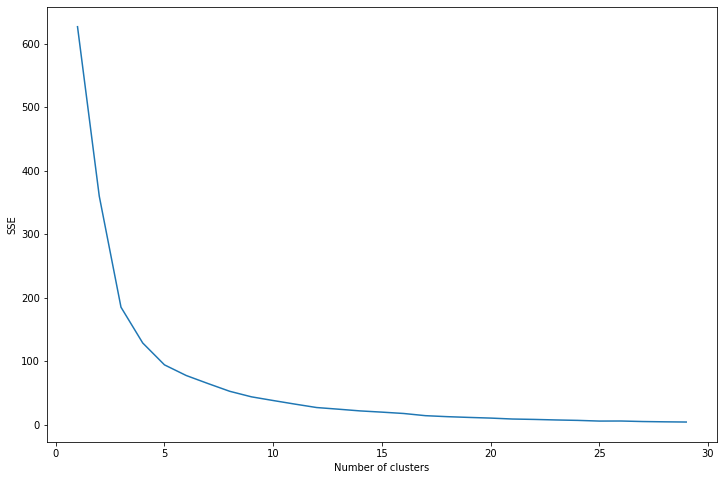

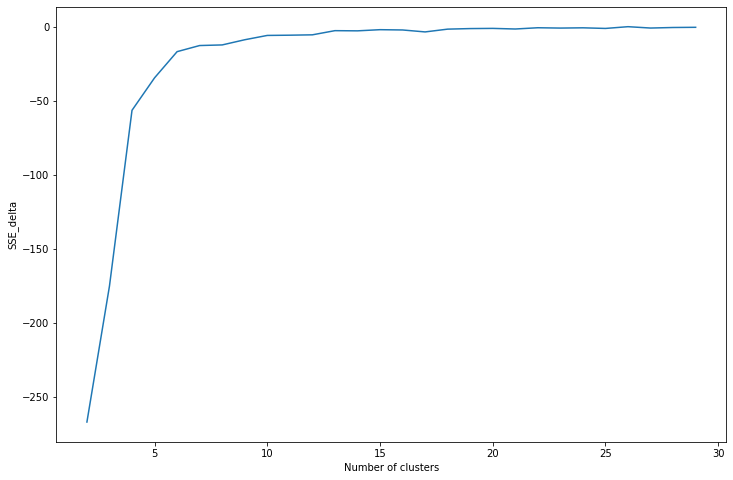

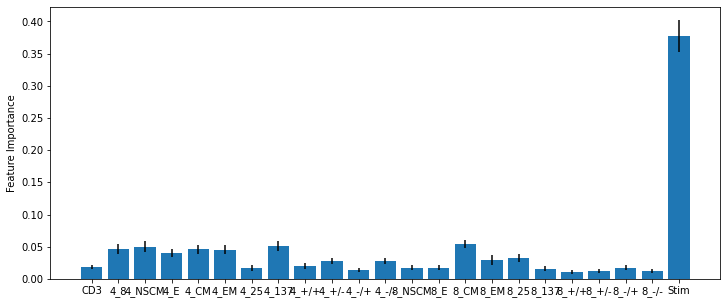

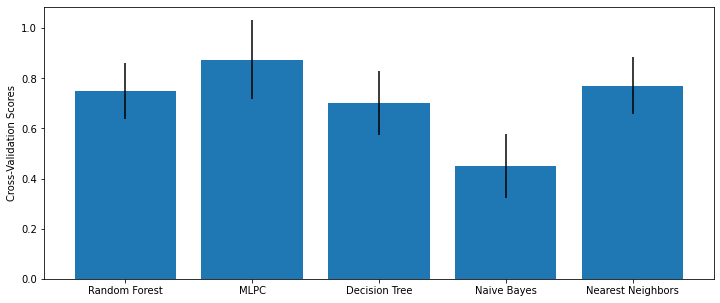

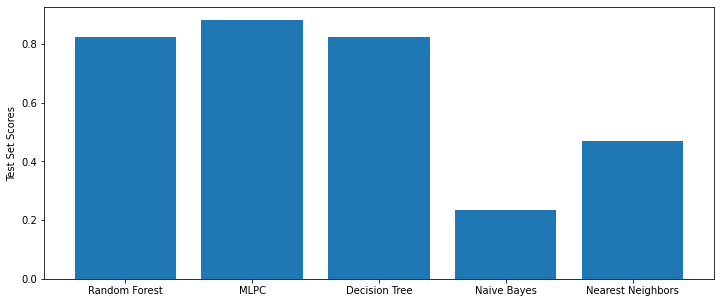

In [4]:
ac_df, hd_df = donor_separator(dfs[2], day = 8)
d0_ac_df, d0_hd_df = donor_separator(dfs[0], day = 0)

for patient_type, d0_df, d8_df in zip(['Diseased', 'Healthy'],[d0_ac_df, d0_hd_df],[ac_df, hd_df]):
    predict_final_cluster(d0_df, d8_df, patient_type, grid_search = False, use_only_stim = False)

## 3. Can we use models to predict what stimulation to give to a certain product?

Given the importance of stimulation and how it varies given the input product, it is important to be able to apply the right stimulation to an input diseased sample to produce a high-quality output product. 

We trained models to predict stimulation when given the input and output phenotype, using the **predict_stimulation_directly** function. By setting the **grid_search** parameter to **True** you can tune model parameters yourself.

We show two scores for each regressor- the first is for the test set of donors that were held out during parameter tuning. The second score is an average of the score when the tuned model is trained on all donors besides one and then made to predict the scores for this held out donor. We have also shown graphs of predicted vs actual stimulation for all samples in this second regime.

The only models which work are random forest regression, and MLP for samples from healthy patients, which show a modest correlation with the data. Linear regression is not able to correctly predict stimulation, even when regularized

,0,Diseased Samples - Score on Test Set,Diseased Samples - Average Score on Single Held-Out Donor,Healthy Samples - Score on Test Set,Healthy Samples - Average Score on Single Held-Out Donor
0,Random Forest Regression,0.606233,0.665792,0.238539,0.347481
1,Ridge Regression,-15.393645,-2.319312,-5.357155,-4.755306
2,Lasso Regression,-2.596680,-0.546013,-2.621260,-2.739475
3,MLP Regression,-4.474058,-0.041381,0.373900,-0.682663


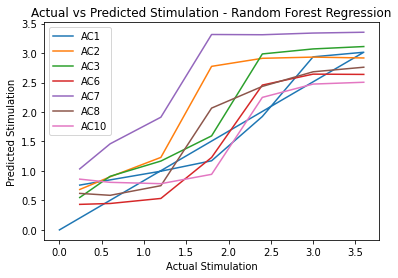

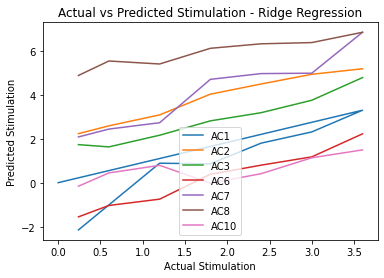

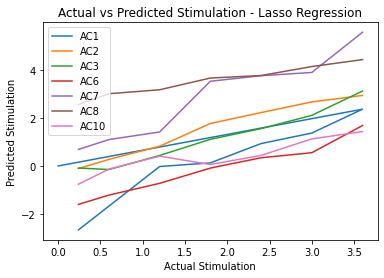

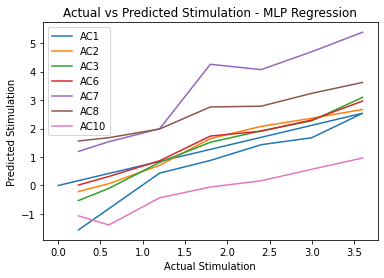

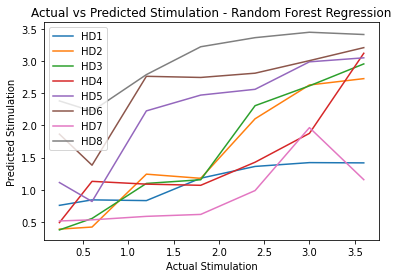

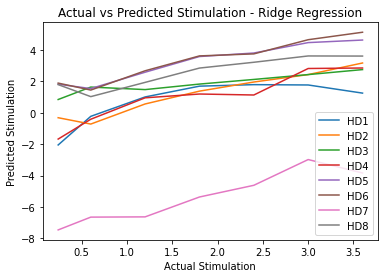

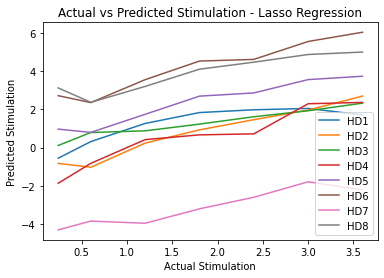

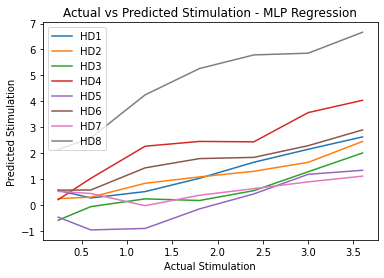

In [7]:
ac_df, hd_df = donor_separator(dfs[2], day = 8)
d0_ac_df, d0_hd_df = donor_separator(dfs[0], day = 0)

rg_names = ['Random Forest Regression', 'Ridge Regression', 'Lasso Regression', 'MLP Regression']
score_df = pd.DataFrame(rg_names)

for patient_type, d0_df, d8_df in zip(['Diseased', 'Healthy'],[d0_ac_df, d0_hd_df],[ac_df, hd_df]):
    new_dfs = [d0_df, d8_df]
    test_scores, single_scores = predict_stimulation_directly(new_dfs, patient_type, grid_search = False)
    score_df['{} Samples - Score on Test Set'.format(patient_type)] = test_scores
    score_df['{} Samples - Average Score on Single Held-Out Donor'.format(patient_type)] = single_scores
score_df